In [652]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Silver 4114 CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake-avx512)
Environment:
  JULIA_NUM_THREADS = 16


In [53]:
using FiniteStateProjection, DiffEqBase, Sobol, JLD2, Plots

include("../generate_data.jl")
include("../train_NN.jl")
include("../viz.jl")
include("afl.jl");

In [10]:
# set up FSP

fsp_sys = FSPSystem(rn_afl, combinatoric_ratelaw=false)
state_space = [2, 400]
u0 = zeros(state_space...)
u0[2, 1] = 1.0
fsp_prob = ODEProblem(fsp_sys, u0, (0., 1.), ones(numreactionparams(rn_afl)))
solver(ts, p) = fsp_solve(fsp_prob, ts, p; marginals=[2], abstol=1e-6, reltol=1e-6)

solver (generic function with 1 method)

In [552]:
# time snapshots
ts = [5, 10, 25, 100]

# ranges for afl parameters
# σ_u σ_b ρ_u ρ_b
ranges = [ 0 2
           0 0.1
           0 10
           0 100 ]

s = SobolSeq(ranges[:,1], ranges[:,2])

ps_train = [ Sobol.next!(s) for i in 1:1000 ]
ps_valid = [ Sobol.next!(s) for i in 1:100 ]
ps_test = [ Sobol.next!(s) for i in 1:500 ]

X_train, y_train = build_dataset_parallel(ts, ps_train, solver)
@save joinpath(AFL_DIR, "train_data.jld2") X_train y_train

X_valid, y_valid = build_dataset_parallel(ts, ps_valid, solver)
@save joinpath(AFL_DIR, "valid_data.jld2") X_valid y_valid

X_test, y_test = build_dataset_parallel(ts, ps_test, solver)
@save joinpath(AFL_DIR, "test_data.jld2") X_test y_test

train_data = (X_train, y_train)
valid_data = (X_valid, y_valid)
test_data = (X_test, y_test);

In [4]:
#@load joinpath(AFL_DIR, "train_data.jld2") X_train y_train
#@load joinpath(AFL_DIR, "valid_data.jld2") X_valid y_valid
#@load joinpath(AFL_DIR, "test_data.jld2") X_test y_test

#train_data = (X_train, y_train)
#valid_data = (X_valid, y_valid)
#test_data = (X_test, y_test);

In [5]:
build_model(n_comps::Int, x::Int) = build_model(n_comps, [x])

function build_model(n_comps::Int, x::Vector{Int}=[32])
    hidden_layers = [Dense(x[i-1], x[i], relu) for i in 2:length(x)]
    model = Chain(InputLayer(),
                  Dense(1 + numparams(rn_afl), x[1], relu),
                  hidden_layers...,
                  MNBOutputLayer(x[end], n_comps)
            )
    MNBModel(model)
end

build_model (generic function with 3 methods)

In [554]:
model = build_model(4, 128)
@time train_losses, valid_losses = train_NN!(model, train_data, valid_data; max_rounds=500, lr=0.01, batchsize=64);

Training...100%|████████████████████████████████████████| Time: 0:02:24


144.781419 seconds (1.31 G allocations: 132.223 GiB, 30.85% gc time, 4.26% compilation time)


In [656]:
println("Training dataset")
println("KLD: ", mean_loss(X_train, y_train, model; loss=loss_kldivergence))
println("Hellinger: ", mean_loss(X_train, y_train, model; loss=loss_hellinger))

println("\nValidation dataset")
println("KLD: ", mean_loss(X_valid, y_valid, model; loss=loss_kldivergence))
println("Hellinger: ", mean_loss(X_valid, y_valid, model; loss=loss_hellinger))

println("\nTest dataset")
println("KLD: ", mean_loss(X_test, y_test, model; loss=loss_kldivergence))
println("Hellinger: ", mean_loss(X_test, y_test, model; loss=loss_hellinger))

#plt = plot([train_losses valid_losses], label=["training" "validation"])
#@save joinpath(AFL_DIR, "model.jld2") model

Training dataset
KLD: 0.0007677949
Hellinger: 0.011964743

Validation dataset
KLD: 0.0009312503
Hellinger: 0.012865164

Test dataset
KLD: 0.0009968214
Hellinger: 0.012780207


In [6]:
#@load joinpath(AFL_DIR, "model.jld2") model

1-element Vector{Symbol}:
 :model

### Example distributions

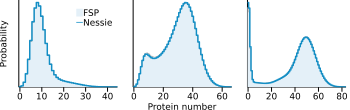

In [200]:
#=
plt1 = plot_dist(X_test[78], test_data, model; true_label="SSA")
plt2 = plot_dist(X_test[75], test_data, model; true_label="FSP")
plt3 = plot_dist(X_test[92], test_data, model; true_label="FSP")
=#

p = Float32.([0.94, 0.01, 8.4, 28.1]); t = 10f0
ps = vcat(t, p); _data = build_dataset([t], [p], solver)
plt1 = plot_dist(ps, _data, model; true_label="FSP")
plt1 = plot!(plt1, xlabel="", ylabel="Probability", title="", yticks=false, left_margin=4Plots.mm, leg=true)

p = Float32.([0.69, 0.07, 7.2, 40.6]); t = 25f0
ps = vcat(t, p); _data = build_dataset([t], [p], solver)
plt2 = plot_dist(ps, _data, model)
plt2 = plot!(plt2, xlabel="Protein number", ylabel="", title="", yticks=false, leg=false, xticks=([0, 20, 40, 60], 0:20:60))

p = Float32.([0.44, 0.08, 0.94, 53.13]); t = 100f0
ps = vcat(t, p); _data = build_dataset([t], [p], solver)
plt3 = plot_dist(ps, _data, model)
plt3 = plot!(plt3, xlabel="", ylabel="", title="", yticks=false,leg=false, right_margin=-1Plots.mm)

plt = plot(plt1, plt2, plt3, layout=(1,3), size=(350, 110), bottom_margin=0Plots.mm, top_margin=-2Plots.mm,
           right_margin=-1Plots.mm, left_margin=1Plots.mm, guidefontsize=6, tickfontsize=6, legendfontsize=6, thickness_scaling=1.0,
           foreground_color_legend = nothing, fmt=:svg)

In [201]:
savefig(joinpath(AFL_DIR, "example_dists.svg"))

### Bimodality heatmaps

In [49]:
cmap_new = [ colorant"#0d89c4", colorant"#2996cb", colorant"#46a4d2", colorant"#63b2d9", colorant"#80c0e0", 
             colorant"#9dcee7", colorant"#badcee", colorant"#d7eaf5", colorant"#f4f8fc", colorant"#eae0e5", 
             colorant"#e1c8ce", colorant"#d7b0b7", colorant"#ce99a0", colorant"#c58189", colorant"#bb6972", 
             colorant"#b2515b", colorant"#a93a45" ]

  0.107879 seconds (257.25 k allocations: 18.837 MiB, 61.05% compilation time)


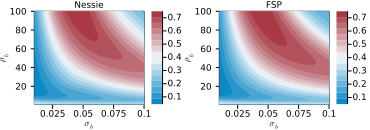

In [214]:
using LaTeXStrings

function plot_bimodality_NN(model, ind1, ind2, iter1, iter2, sym1, sym2, ps, t)

    bcs = Matrix{Float64}(undef, length(iter1), length(iter2))
    ps_all = vcat(t, ps...) 
    ind1 += 1; ind2 +=1

    for (i, p1) in enumerate(iter1)
        
        for (j, p2) in enumerate(iter2)
            
            ps_all[ind1] = p1; ps_all[ind2] = p2 
            mnb = Distribution(model, ps_all)
            bcs[i, j] = bimodcoeff(mnb)
            
        end
        
    end

    plt = contourf(iter1, iter2, bcs', linewidth=0.005, c=cmap_new, linecolor=:black)
    plt = plot!(plt, xlabel=sym1, ylabel=sym2)
    plt, bcs

end

function plot_bimodality_FSP(ind1, ind2, iter1, iter2, sym1, sym2, ps, t)

    fsp_sys = FSPSystem(rn_afl, combinatoric_ratelaw=false)
    state_space = [2, 400]
    u0 = zeros(state_space...)
    u0[2, 1] = 1.0
    fsp_prob = ODEProblem(fsp_sys, u0, (0., t), ones(numparams(rn_afl)))

    bcs = Matrix{Float64}(undef, length(iter1), length(iter2))

    Threads.@threads for (i, j) in collect(Iterators.product(1:length(iter1), 1:length(iter2)))
        p1 = iter1[i]
        p2 = iter2[j]

        ps_ = copy(ps)
        ps_[ind1] = p1; ps_[ind2] = p2 
        sol_raw = solve(fsp_prob, CVODE_BDF(), saveat=[t], p=ps_; reltol=1e-8, abstol=1e-8)

        dist = sum(sol_raw.u[1], dims=1)[1:end]
        max_ind = maximum(findall(val -> !isapprox(val, 0f0, atol=1e-5), dist))
        dist = dist[1:max_ind]

        m = sum( (0:max_ind-1) .* dist )
        s = sqrt(sum( ((0:max_ind-1) .- m) .^2 .* dist ))
        m3 = sum(((0:max_ind-1) .- m) .^3 .* dist)
        m4 = sum( ((0:max_ind-1) .- m) .^4 .* dist)
        bcs[i, j] = 1 / (m4/s^4 - (m3 / s^3)^2)
        
    end

    plt = contourf(iter1, iter2, bcs', linewidth=0.02, c=cmap_new)
    plt = plot!(plt, xlabel=sym1, ylabel=sym2)

    plt, bcs

end

# σ_u σ_b ρ_u ρ_b
ranges = [ 0 2
           0 0.1
           0 10
           0 100 ]

ps = [1f0, 0.05f0, 1f0, 20f0]

iter1 = 0.01:0.002:0.1
iter2 = 1:1:100
sym1 = "σ_b"
sym2 = "ρ_b"
@time plt1, bcs_nn = plot_bimodality_NN(model, 2, 4, iter1, iter2, sym1, sym2, ps, 100f0)
plt1 = plot!(plt1, xlabel=L"\sigma_b", ylabel=L"\rho_b", title="Nessie", xticks=xticks)

#@time plt2, bcs_fsp = plot_bimodality_FSP(2, 4, iter1, iter2, sym1, sym2, ps, 100f0)
#plt2 = plot!(plt2, xlabel=L"\sigma_b", ylabel=L"\rho_b"); plot(plt2)
#@save joinpath(AFL_DIR, "heatmap_bcs_FSP.jld2") bcs_fsp

xticks = (0.025:0.025:0.1, 0.025:0.025:0.1)
@load joinpath(AFL_DIR, "heatmap_bcs_FSP.jld2") bcs_fsp
plt2 = contourf(iter1, iter2, bcs_fsp', c=cmap_new, linewidth=0.005, linecolor=:black, xticks=xticks)
plt2 = plot!(plt2, xlabel=L"\sigma_b", ylabel=L"\rho_b", title="FSP")

lim1, lim2 = extrema(hcat(bcs_nn, bcs_fsp))
plt = plot(plt1, plt2, clim=(lim1, lim2), size = (370, 130), tick_direction = :out, thickness_scaling=1.0,
           guidefontsize=6, tickfontsize=6, legendfontsize=6, ticksize=6, titlefontsize=6,
           left_margin=-1Plots.mm, bottom_margin=0.5Plots.mm, top_margin=-1Plots.mm, right_margin=-1Plots.mm, 
           framestyle=:box)

In [215]:
savefig(joinpath(AFL_DIR, "bimodality.svg"))

In [616]:
@time plot_bimodality_NN(model, 2, 4, iter1, iter2, sym1, sym2, ps, 100f0);

  0.030168 seconds (227.87 k allocations: 17.381 MiB)


In [629]:
@time plot_bimodality_FSP(2, 4, iter1, iter2, sym1, sym2, ps, 100f0);

240.411449 seconds (90.87 M allocations: 4.119 GiB, 0.21% gc time)


### Predicted vs true moments

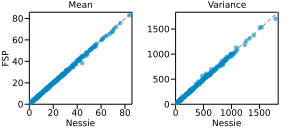

In [216]:
# considering only t=100
m_NN = mean.(Distribution.(Ref(model), X_test[1:4:end]))
var_NN = var.(Distribution.(Ref(model), X_test[1:4:end]))

m_FSP = [sum((0:length(y)-1) .* y) for y in y_test[1:4:end]]
var_FSP = [sum(((0:length(y)-1) .- m_FSP[i]) .^2  .* y) for (i, y) in enumerate(y_test[1:4:end])] 

max_val = maximum(vcat(m_FSP, m_NN))*1.025
plt1 = plot(1:max_val, 1:max_val, linestyle=:dash, linecolor=:gray, linealpha=0.9, legend=false, xlabel="Nessie", ylabel="FSP", title="Mean")
plt1 = scatter!(plt1, m_NN, m_FSP, color=colorant"#0088c3ff", grid = false, xlim=(0, max_val), ylim=(0, max_val), markersize=2.5, markerstrokecolor=colorant"#0088c3ff", alpha=0.6)
plt1 = plot!(plt1, guidefontsize=6, tickfontsize=6, titlefontsize=6, thickness_scaling=1.0, framestyle=:box, tick_direction=:out)
#savefig(joinpath(AFL_DIR, "true_vs_predict_mean.svg"))

max_val = maximum(vcat(var_FSP, var_NN))*1.025
plt2 = plot(1:max_val, 1:max_val, linestyle=:dash, linecolor=:gray, linealpha=0.9, legend=false, xlabel="Nessie", title="Variance")
plt2 = scatter!(plt2, var_NN, var_FSP, color=colorant"#0088c3ff", grid = false, xlim=(0, max_val), ylim=(0, max_val), markersize=2.5, markerstrokecolor=colorant"#0088c3ff", alpha=0.6)
plt2 = plot!(plt2, guidefontsize=6, tickfontsize=6, titlefontsize=6, thickness_scaling=1.0, framestyle=:box, tick_direction=:out)
#savefig(joinpath(AFL_DIR, "true_vs_predict_variance.svg"))

plt = plot(plt1, plt2, size=(290, 130), left_margin=-1Plots.mm, bottom_margin=0Plots.mm, top_margin=-1Plots.mm, right_margin=1Plots.mm)

In [210]:
savefig(joinpath(AFL_DIR, "true_vs_predicted_moments.svg"))

# Hyperparameter tuning

### Size of the dataset

In [619]:
nsamples = 10
nparams = [50, 100, 200, 300, 400, 500, 750, 1000];

In [ ]:
models = []
@time for nparam in nparams
    
    _models = []

    for i in 1:nsamples

        tpts = [ Sobol.next!(s) for i in 1:nparam]
        _train = build_dataset_parallel(ts, tpts, solver)
        
        vpts = [ Sobol.next!(s) for i in 1:100]
        _valid = build_dataset_parallel(ts, vpts, solver)
        
        model = build_model(4, 128)
        _, _ = train_NN!(model, _train, _valid; max_rounds=500, lr=0.01, batchsize=64)
        push!(_models, model)
    end
    
    push!(models, _models)

end

#@save joinpath(AFL_DIR, "models_nparams.jld2") models

Generating data...  35%|███████████▍                    |  ETA: 0:01:16
  parameter_set:  [1.500823974609375, 0.04264678955078125, 3.955535888671875, 62.44964599609375]

In [620]:
@load joinpath(AFL_DIR, "models_nparams.jld2") models

1-element Vector{Symbol}:
 :models

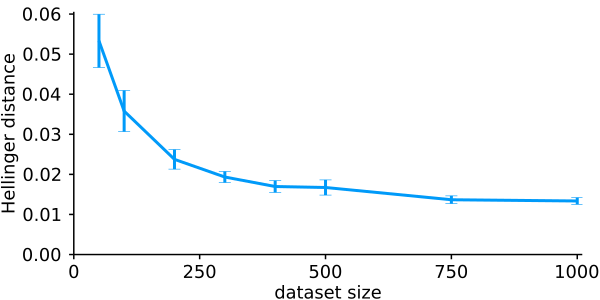

In [621]:
losses_hell = [ [ mean_loss(valid_data..., model; loss=loss_hellinger) for model in models[i] ] for i in 1:length(models)]

x = nparams
y = mean.(losses_hell)
ystd = std.(losses_hell)
ind = findmax(y)[2]
ymax = (y[ind] + ystd[ind]) * 1.01
xmax = x[end] * 1.01

plt_hell = plot(x, y, yerror=ystd, xlabel="dataset size", ylabel="Hellinger distance", 
                markerstrokecolor = :auto, leg=false, grid=false, lw=2, ylim=(0., ymax), xlim = (0., xmax),
                markerstrokewidth=2, tick_direction=:out, 
                size = (600, 300), guidefontsize=8, tickfontsize=8, legendfontsize=8, thickness_scaling=1.5,
                left_margin=-5Plots.mm, right_margin=1Plots.mm, top_margin=0Plots.mm, bottom_margin=-2Plots.mm)

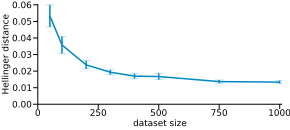

In [622]:
plt_hell = plot(x, y, yerror=ystd, xlabel="dataset size", ylabel="Hellinger distance", 
                markerstrokecolor = colorant"#0088c3ff", leg=false, grid=false, lw=1.5, ylim=(0., ymax), xlim = (0., xmax),
                markerstrokewidth=1.5, tick_direction=:out, c=colorant"#0088c3ff",
                size = (290, 130), guidefontsize=6, tickfontsize=6, thickness_scaling=1.0,
                left_margin=-1Plots.mm, right_margin=0Plots.mm, top_margin=-1Plots.mm, bottom_margin=0Plots.mm)

In [623]:
savefig(joinpath(AFL_DIR, "hell_vs_nparams.svg"))

### Number of mixture components

In [624]:
nsamples = 10
ncomps = 1:10;

In [ ]:
models = []
@time for ncomp in ncomps
    
    _models = []
    
    for i in 1:nsamples
         tpts = [ Sobol.next!(s) for i in 1:1000]
        _train = build_dataset_parallel(ts, tpts, solver)
        
        vpts = [ Sobol.next!(s) for i in 1:100]
        _valid = build_dataset_parallel(ts, vpts, solver)
        
        model = build_model(ncomp, 128)
        _, _ = train_NN!(model, _train, _valid; max_rounds=500, lr=0.01, batchsize=64)
        push!(_models, model)
    end
    
    push!(models, _models)

end

#@save joinpath(AFL_DIR, "models_ncomps.jld2") models

Training... 73%|█████████████████████████████           |  ETA: 0:01:09
  iter:           364
  learning_rate:  0.0003125
  train_loss:     0.0030511012
  valid_loss:     0.0039099175

In [625]:
@load joinpath(AFL_DIR, "models_ncomps.jld2") models

1-element Vector{Symbol}:
 :models

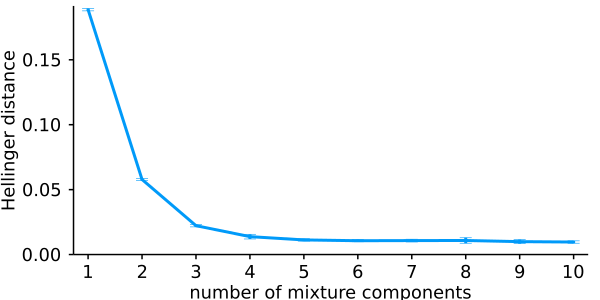

In [626]:
losses_hell = [ [ mean_loss(valid_data..., model; loss=loss_hellinger) for model in models[i] ] for i in 1:length(models)]

x = ncomps
y = mean.(losses_hell)
ystd = std.(losses_hell)
ind = findmax(y)[2]
ymax = (y[ind] + ystd[ind]) * 1.01

plt_hell = plot(x, y, yerror=ystd, xlabel="number of mixture components", ylabel="Hellinger distance", 
                markerstrokecolor = :auto, leg=false, grid=false, lw=2, ylim=(0., ymax),
                markerstrokewidth=2, tick_direction=:out, xticks=x,
                size = (600, 300), guidefontsize=8, tickfontsize=8, legendfontsize=8, thickness_scaling=1.5,
                left_margin=-5Plots.mm, right_margin=0Plots.mm, top_margin=-1Plots.mm, bottom_margin=-2Plots.mm)

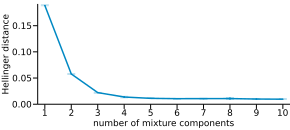

In [627]:
plt_hell = plot(x, y, yerror=ystd, xlabel="number of mixture components", ylabel="Hellinger distance", 
                markerstrokecolor = colorant"#0088c3ff", leg=false, grid=false, lw=1.5, ylim=(0., ymax),
                markerstrokewidth=1.5, tick_direction=:out, c=colorant"#0088c3ff", xticks=x,
                size = (290, 130), guidefontsize=6, tickfontsize=6, thickness_scaling=1.0,
                left_margin=-1Plots.mm, right_margin=-2Plots.mm, top_margin=-1Plots.mm, bottom_margin=0Plots.mm)

In [628]:
savefig(joinpath(AFL_DIR, "hell_vs_ncomps.svg"))

### Number of neurons in the single hidden layer

In [641]:
nsamples = 10
nunits = 2 .^(1:10);

In [ ]:
models = []
@time for nunit in nunits
    
    _models = []
    
    for i in 1:nsamples
         tpts = [ Sobol.next!(s) for i in 1:1000]
        _train = build_dataset_parallel(ts, tpts, solver)
        
        vpts = [ Sobol.next!(s) for i in 1:100]
        _valid = build_dataset_parallel(ts, vpts, solver)
        
        model = build_model(4, nunit)
        _, _ = train_NN!(model, _train, _valid; max_rounds=500, lr=0.01, batchsize=64)
        push!(_models, model)
    end
    
    push!(models, _models)

end

#@save joinpath(AFL_DIR, "models_nunits.jld2") models

Training... 52%|████████████████████▊                   |  ETA: 0:01:47
  iter:           261
  learning_rate:  0.0025
  train_loss:     0.024096008
  valid_loss:     0.024623724

In [642]:
@load joinpath(AFL_DIR, "models_nunits.jld2") models

1-element Vector{Symbol}:
 :models

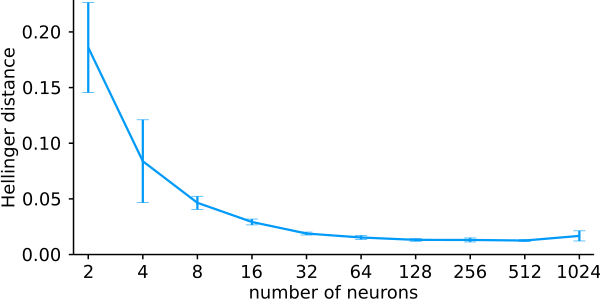

In [643]:
losses_hell = [ [ mean_loss(valid_data..., model; loss=loss_hellinger) for model in models[i] ] for i in 1:length(models)]

x = string.(nunits)
y = mean.(losses_hell)
ystd = std.(losses_hell)
ind = findmax(y)[2]
ymax = (y[ind] + ystd[ind]) * 1.01

plt_hell = plot(x, y, yerror=ystd, xlabel="number of neurons", ylabel="Hellinger distance", 
                markerstrokecolor = :auto, leg=false, grid=false, lw=2, ylim=(0., ymax),
                markerstrokewidth=2, tick_direction=:out,
                size = (600, 300), guidefontsize=8, tickfontsize=8, legendfontsize=8, thickness_scaling=1.5,
                left_margin=-5Plots.mm, right_margin=-1Plots.mm, top_margin=-2Plots.mm, bottom_margin=-2Plots.mm)

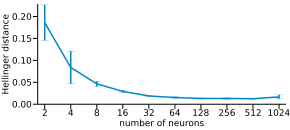

In [644]:
plt_hell = plot(x, y, yerror=ystd, xlabel="number of neurons", ylabel="Hellinger distance",
                markerstrokecolor = colorant"#0088c3ff", leg=false, grid=false, lw=1.5, ylim=(0., ymax),
                markerstrokewidth=1.5, tick_direction=:out, c=colorant"#0088c3ff",
                size = (290, 130), guidefontsize=6, tickfontsize=6, thickness_scaling=1.0,
                left_margin=-1Plots.mm, right_margin=-1Plots.mm, top_margin=-1Plots.mm, bottom_margin=0Plots.mm)

In [645]:
savefig(joinpath(AFL_DIR, "hell_vs_nunits.svg"))

### Different deep architectures

In [646]:
nlayers = [[128], [128, 128], [64, 16], [128, 64, 32], [64, 32, 16], [64, 64, 32, 32], [16, 16, 16, 16]]
nsamples = 10;

In [ ]:
models = []
@time for nlayer in nlayers
    
    _models = []
    
    for i in 1:nsamples
         tpts = [ Sobol.next!(s) for i in 1:1000]
        _train = build_dataset_parallel(ts, tpts, solver)
        
        vpts = [ Sobol.next!(s) for i in 1:100]
        _valid = build_dataset_parallel(ts, vpts, solver)
        
        model = build_model(4, nlayer)
        _, _ = train_NN!(model, _train, _valid; max_rounds=500, lr=0.01, batchsize=64)
        push!(_models, model)
    end
    
    push!(models, _models)

end

#@save joinpath(AFL_DIR, "models_nlayers.jld2") models

Training...100%|████████████████████████████████████████| Time: 0:03:05


In [647]:
@load joinpath(AFL_DIR, "models_nlayers.jld2") models

1-element Vector{Symbol}:
 :models

In [648]:
losses_hell = [ [ mean_loss(valid_data..., model; loss=loss_hellinger) for model in models[i] ] for i in 1:length(models)]
labels = ["128", "128-128", "64-16", "128-64-32", "64-32-16", "64-64-32-32", "16-16-16-16"];

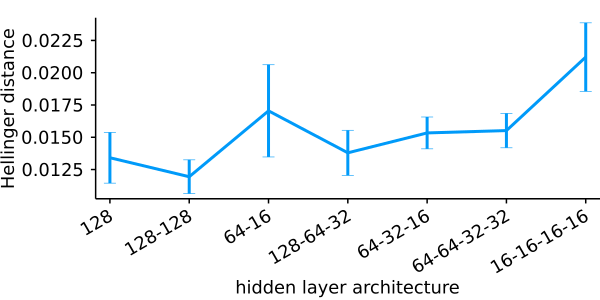

In [649]:
plot(labels, mean.(losses_hell), yerror=std.(losses_hell), 
     xlabel="hidden layer architecture", ylabel="Hellinger distance", 
     markerstrokecolor = :auto, leg=false, grid=false, lw=2, markerstrokewidth=2, tick_direction=:out,
     size = (600, 300), guidefontsize=8, tickfontsize=8, legendfontsize=8, thickness_scaling=1.5, xrotation = 30,
     left_margin=-7Plots.mm, right_margin=-2Plots.mm)

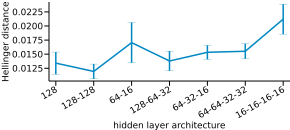

In [650]:
plt_hell = plot(labels, mean.(losses_hell), yerror=std.(losses_hell), 
                xlabel="hidden layer architecture", ylabel="Hellinger distance", 
                markerstrokecolor = colorant"#0088c3ff", leg=false, grid=false, lw=1.5,
                markerstrokewidth=1.5, tick_direction=:out, c=colorant"#0088c3ff",
                size = (290, 130), guidefontsize=6, tickfontsize=6, thickness_scaling=1.0, xrotation = 30,
                left_margin=-1Plots.mm, right_margin=-2Plots.mm, top_margin=-1.5Plots.mm, bottom_margin=3Plots.mm)

In [651]:
savefig(joinpath(AFL_DIR, "hell_vs_architecture.svg"))

### Number of SSA trajectories

In [377]:
# set up SSA
u0 = [1, 0] # [G, P]
jsys = convert(JumpSystem, rn_afl, combinatoric_ratelaws=false)
dprob = DiscreteProblem(jsys, u0, (0., 1.), ones(numparams(rn_afl)))
jprob = JumpProblem(jsys, dprob, Direct(), save_positions=(false,false));

In [338]:
ntrajs = Int.([1, 5, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4])
nsamples = 10;

In [ ]:
models = []

@time for ntraj in ntrajs
    
    ssa_solver(ts, p) = ssa_solve(jprob, ts, p, ntraj; marginals=[2])
    _models = []
    
    for i in 1:nsamples
        tpts = [ Sobol.next!(s) for i in 1:1000 ]
        _train = build_dataset(ts, tpts, ssa_solver) # SSA
        
        vpts = [ Sobol.next!(s) for i in 1:100 ]
        _valid = build_dataset_parallel(ts, vpts, solver) # FSP
        
        model = build_model(4, 128)
        _, _ = train_NN!(model, _train, _valid; max_rounds=500, lr=0.01, batchsize=64)
        push!(_models, model)
    end
    
    push!(models, _models)

end

#@save joinpath(AFL_DIR, "models_ntrajs.jld2") models

Training... 43%|█████████████████▎                      |  ETA: 0:01:36
  iter:           216
  learning_rate:  0.00125
  train_loss:     0.066207856
  valid_loss:     0.0017374638

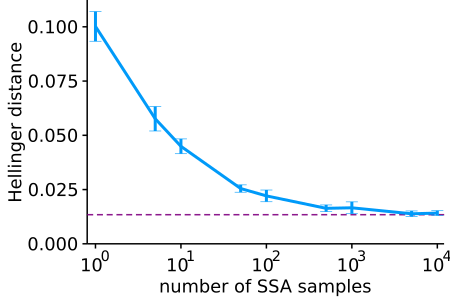

In [340]:
# add FSP as a purple dashed line
# using the 1st model from "models_nlayers.jld2" as that's we need
@load joinpath(AFL_DIR, "models_nlayers.jld2") models
fsp_res = mean([ mean_loss(valid_data..., model; loss=loss_hellinger) for model in models[1] ])
_x = [ntrajs[1]-0.2, ntrajs..., ntrajs[end]*1.3]; _y = fill(fsp_res,length(_x))
plt_hell = plot(_x, _y, linestyle=:dash, lw=1, linealpha=0.9, linecolor=:purple)

@load joinpath(AFL_DIR, "models_ntrajs.jld2") models
losses_hell = [ [ mean_loss(valid_data..., model; loss=loss_hellinger) for model in models[i] ] for i in 1:length(models)]
y = mean.(losses_hell)
ystd = std.(losses_hell)
ind = findmax(y)[2]
ymax = (y[ind] + ystd[ind]) * 1.05

plt_hell = plot!(plt_hell, ntrajs, y, yerror=ystd, ylim = (0., ymax), color=1,
                xlabel="number of SSA samples", ylabel="Hellinger distance", legend=false, xlim=(ntrajs[1]-0.2, ntrajs[end]*1.2),
                markerstrokecolor = 1, markerstrokewidth=2, grid=false, lw=2, xaxis=:log,
                size=(450, 300),  guidefontsize=8, tickfontsize=8, legendfontsize=8, thickness_scaling=1.5,
                left_margin=-6Plots.mm, bottom_margin=-3Plots.mm, right_margin=-1Plots.mm, top_margin=-2Plots.mm,tick_direction=:out)

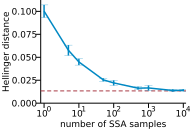

In [602]:
plt_hell = plot(_x, _y, linestyle=:dash, lw=1.0, linealpha=1.0, linecolor=colorant"#a93a45")

plt_hell = plot!(plt_hell, ntrajs, y, yerror=ystd, ylim = (0., ymax), c=colorant"#0088c3ff",
                xlabel="number of SSA samples", ylabel="Hellinger distance", legend=false, xlim=(ntrajs[1]-0.2, ntrajs[end]*1.2),
                markerstrokecolor = colorant"#0088c3ff", markerstrokewidth=1.5, grid=false, lw=1.5, xaxis=:log,
                size=(190, 130),  guidefontsize=6, tickfontsize=6, thickness_scaling=1.0,
                left_margin=-2Plots.mm, bottom_margin=-1.5Plots.mm, right_margin=-1Plots.mm, top_margin=-2Plots.mm, tick_direction=:out)

In [603]:
savefig(joinpath(AFL_DIR, "hell_vs_ssa.svg"))

#### Noisiness in histograms

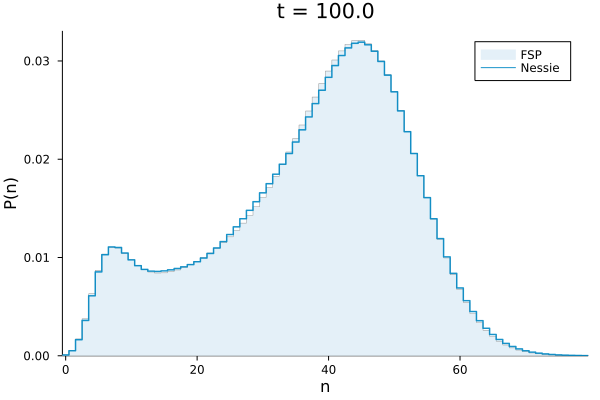

In [373]:
ind = 143
plot_dist(X_test[ind*4], test_data, model; true_label="FSP")

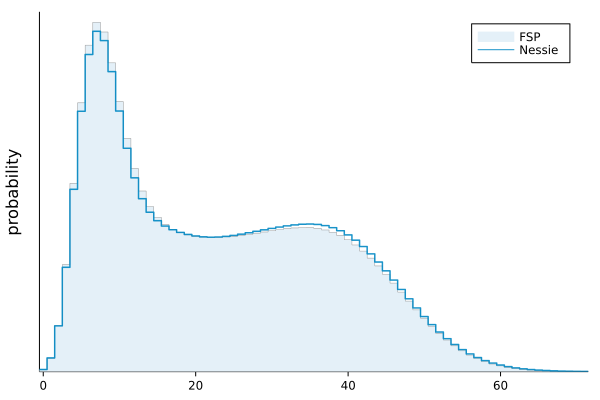

In [374]:
p = Float32.([1.17, 0.05, 6.9, 47.9]); t = 10f0
ps = vcat(t, p); _data = build_dataset([t], [p], solver)

plt1 = plot_dist(ps, _data, model; true_label="FSP")
plt1 = plot!(plt1, xlabel="", ylabel="probability", title="", yticks=false, left_margin=4Plots.mm, leg=true)

In [375]:
@load joinpath(AFL_DIR, "models_ntrajs.jld2") models
p = Float32.([1.17, 0.05, 6.9, 47.9]); t = 10f0
ps = vcat(t, p)
ylim = 0.052
xlim = 65
xticks = 0:20:60;

In [592]:
_solver(t, p) = ssa_solve(jprob, t, p, 100; marginals=[2])
_data1 = build_dataset(t, [p], _solver)

dif = xlim+1-length(_data1[2][1])
if dif > 0
    _data1[2][1] = vcat(_data1[2][1], zeros(Float32, dif))
end
plt1 = plot_dist(ps, _data1, models[5][rand(1:10)]; true_label="SSA", title="", xticks=xticks)
plt1 = plot!(plt1, xlabel="", yticks=false, ylabel="Probability", left_margin=0Plots.mm)
plt1 = plot!(plt1, ylims=(0., ylim), xlims=(0., xlim), leg=false)
plt1 = annotate!(plt1, [(30, ylim-0.002, Plots.text("10²", 8, :black, :center))])

_solver(t, p) = ssa_solve(jprob, t, p, 1000; marginals=[2])
_data2 = build_dataset(t, [p], _solver)
dif = xlim+1-length(_data2[2][1])
if dif > 0
    _data2[2][1] = vcat(_data2[2][1], zeros(Float32, dif))
end
plt2 = plot_dist(ps, _data2, models[7][rand(1:10)], xticks=xticks, true_label="SSA")
plt2 = plot!(plt2, xlabel="Protein number", ylabel="", title="", leg=true, yticks=false, foreground_color_legend = nothing) 
plt2 = plot!(plt2, ylims=(0., ylim), xlims=(0., xlim))
plt2 = annotate!(plt2, [(33, ylim-0.002, Plots.text("10³", 8, :black, :center))])

_solver(t, p) = ssa_solve(jprob, t, p, 10000; marginals=[2])
_data3 = build_dataset(t, [p], _solver)
dif = xlim+1-length(_data3[2][1])
if dif > 0
    _data3[2][1] = vcat(_data3[2][1], zeros(Float32, dif))
end
plt3 = plot_dist(ps, _data3, models[9][rand(1:10)], xticks=xticks)
plt3 = plot!(plt3, xlabel="", ylabel="", title="", leg=false, yticks=false) 
plt3 = plot!(plt3, ylims=(0., ylim), xlims=(0., xlim))
plt3 = annotate!(plt3, [(33, ylim-0.002, Plots.text("10⁴", 8, :black, :center))]);

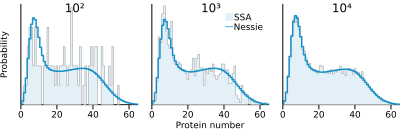

In [595]:
plt = plot(plt1, plt2, plt3, layout=(1,3), size=(400, 130), legendfontsize=6,
           guidefontsize=6, tickfontsize=6, ticksize=6, thickness_scaling=1.0, tick_orientation=:out,
           top_margin=-1Plots.mm, bottom_margin=0.5Plots.mm, left_margin=1.5Plots.mm, right_margin=-2Plots.mm)

In [596]:
savefig(joinpath(AFL_DIR, "SSA_dists.svg"))